# quick notebook for checking energy distributions post-cuts

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_master/IC/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


import functions.functions_HE as func


In [19]:
#RUN_NUMBER = '15594'
#TIMESTAMP  = '160725'
RUN_NUMBER = ['15589', '15590', '15591', '15592', '15593', '15594', '15596']
TIMESTAMP  = ['110725', '120725', '130725', '140725', '150725', '160725', '170725']

In [20]:
# READ IN THE DF
data = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    
    path = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/cut_hdst.h5'
    data.append(pd.read_hdf(path, key = 'Tracking/Tracks'))
#data = pd.read_hdf(path, key = 'Tracking/Tracks')
data = pd.concat(data)

In [21]:
display(data)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
52,1503454,0,1.504076,350.854095,413,970,1,227.675,-124.775,581.995250,...,712.984493,288.875,45.275,745.520375,0.627175,0.106990,0.0,13.711111,14.380000,13.945205
58,2816878,0,1.601952,235.386047,400,998,1,-328.125,13.675,800.407250,...,820.093245,-281.475,90.925,927.460906,0.627431,0.310738,0.0,14.380000,13.845000,14.825920
82,2817410,0,1.546169,234.974089,308,761,1,57.625,183.725,540.069125,...,601.233565,196.575,338.225,559.688730,0.668175,0.547256,0.0,14.380000,14.453125,13.060304
323,1578620,0,1.676808,266.061459,386,971,1,104.275,-0.875,447.131375,...,535.519947,243.225,91.425,466.423904,0.841642,0.191136,0.0,14.380000,14.296429,13.690069
339,179054,0,1.670595,327.644806,327,749,1,-81.325,-0.875,89.736875,...,137.632134,149.925,75.875,146.514556,0.851438,0.243256,0.0,14.626316,14.380000,13.776958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92397,2274328,0,1.504461,189.881776,307,781,1,119.825,-31.975,530.321000,...,566.675249,181.025,75.875,668.266698,0.817337,0.299842,0.0,13.954545,14.087500,14.267958
92455,3135041,0,1.610490,291.246885,389,916,1,-173.625,106.975,421.777500,...,497.585463,-19.125,214.825,440.238210,0.684054,0.280478,0.0,14.517647,14.517647,13.406453
92524,2785895,0,1.603729,370.414177,315,768,1,149.925,122.025,230.006500,...,250.467706,196.575,260.475,476.528051,0.505162,0.164816,0.0,14.045455,14.413333,14.607146
92535,2101855,0,1.645362,360.747496,423,1094,1,-312.575,-63.075,695.630750,...,732.784046,-34.675,-0.875,881.006914,0.373334,0.166337,0.0,14.743478,13.895000,14.810741


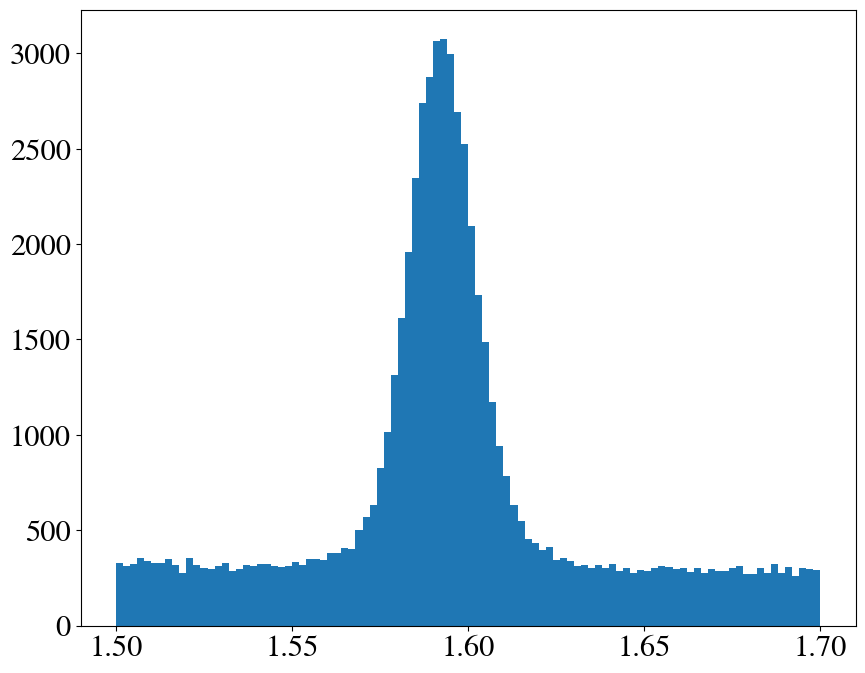

In [22]:
plt.hist(data.energy, bins = 100)
plt.show()

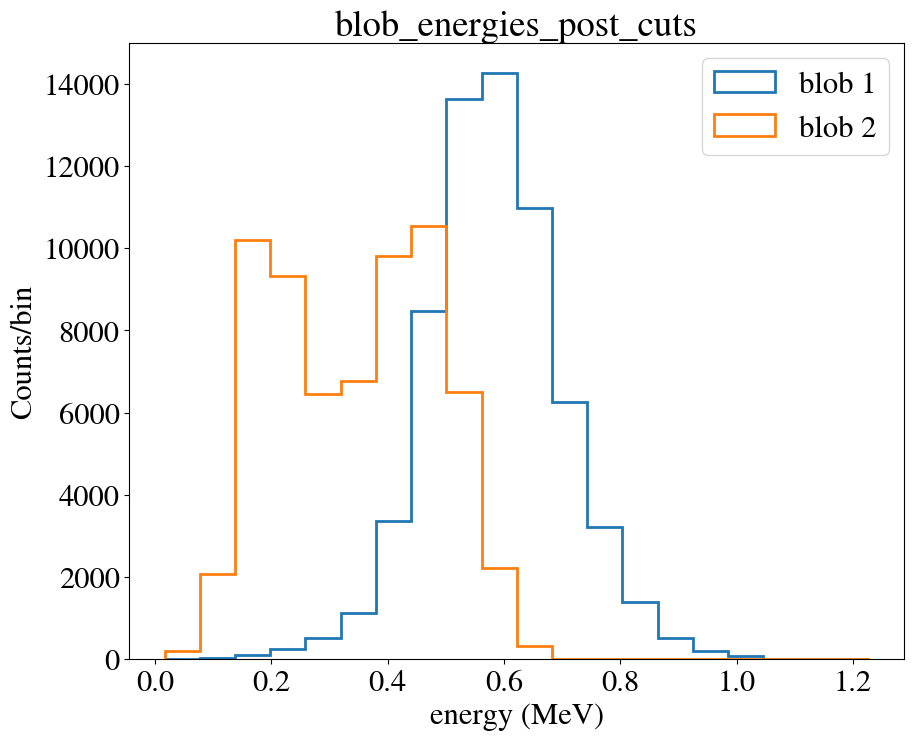

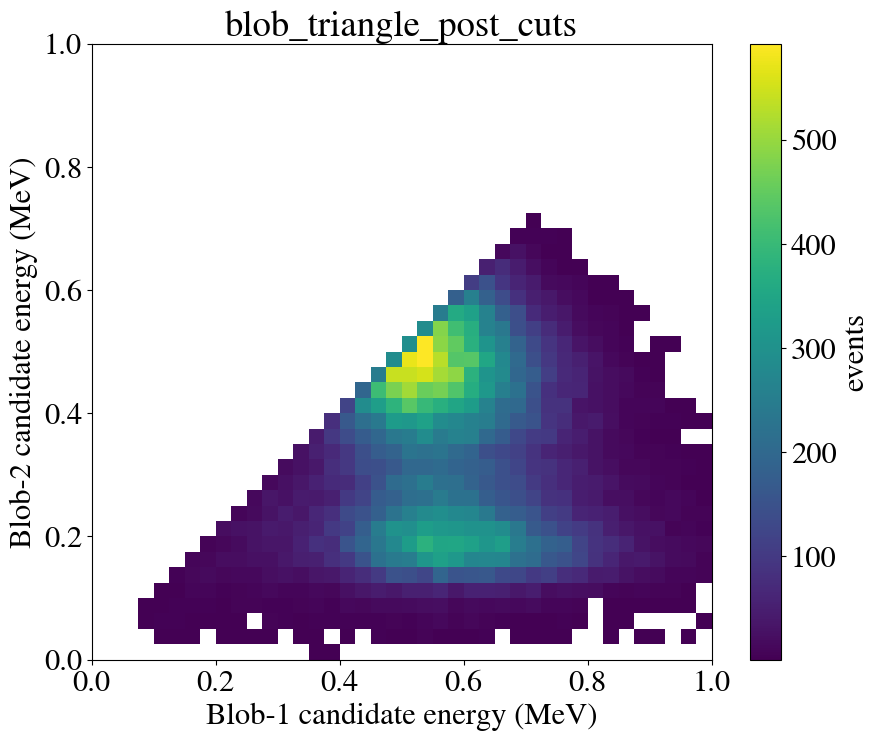

In [24]:
blob_title        = f'blob_energies_post_cuts'
blob_2dhits_title = f'blob_triangle_post_cuts'
# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(data['eblob1'].to_numpy())
eblob_full.append(data['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)

func.plot_hist(data, column = 'eblob1', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
func.plot_hist(data, column = 'eblob2', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
#plt.savefig(f'{folder_name}blob/{blob_title}.png')
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(data['eblob1'], data['eblob2'], bins=(40, 40), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title(f'{blob_2dhits_title}')
#plt.savefig(f'{folder_name}blob/{blob_2dhits_title}.png')
plt.show()